# Load the zip file and unzip and before check the GPU

In [1]:
# Check the GPU is available or not
# IMPORT
import tensorflow as tf 

# FETCH GPU NAME
device_name = tf.test.gpu_device_name()

# IF DEVICE IS NOT AVAILABLE FETCH ERROR
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
    
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# IMPORT DEPENDENCIES

import requests, zipfile, io
from glob import glob
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
from tqdm import tqdm
import cv2
import pandas as pd
seed = 7
import pandas as pd
np.random.seed(seed)
import os

In [0]:
zip_file_url = 'https://github.com/karoldvl/ESC-50/archive/master.zip' # link: ESC-50 Datset

In [0]:
# CREATE FOLDER WITH NAME SOUND IF NOT EXIST
if not os.path.exists('sound'):
    os.makedirs('sound')

In [0]:
# UNZIP THE DATA AND EXTRACT ALL FILES IN THE SOUND FOLDER
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('sound/')
z.close()

In [0]:
# glob('sound/ESC-50-master/audio/*')

# Define a function to covert the image based on calculate log scaled mel-spectrograms and their corresponding deltas from a sound clip.

Regarding fixed size input, we will divide each sound clip into segments of 60x41 (60 rows and 41 columns). The mel-spec and their deltas will become two channels, which we will be fed into CNN

In [0]:
# !pip install librosa
import librosa

In [0]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

def extract_features(bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for fn in tqdm(glob('sound/ESC-50-master/audio/*')):
        sound_clip,s = librosa.load(fn) # 5sec
        sound_clip   = np.concatenate((sound_clip,sound_clip),axis=None) # make it 10s
        label = fn.split("/")[-1].split("-")[-1].split(".")[0]
        for (start,end) in windows(sound_clip,window_size):
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]
                melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                logspec = librosa.core.amplitude_to_db(melspec)
                logspec = logspec.T.flatten()[:, np.newaxis].T
                log_specgrams.append(logspec)
                labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)

In [9]:
features,labels = extract_features()

100%|██████████| 2000/2000 [16:42<00:00,  1.99it/s]


In [10]:
# label category names
df = pd.read_csv(glob('sound/ESC-50-master/meta/esc50.csv')[0])
df = df[['target','category']]
df = df.drop_duplicates().reset_index(drop=True)
df = df.sort_values(by=['target']).reset_index(drop=True)
df.head()

,target,category
0,0,dog
1,1,rooster
2,2,pig
3,3,cow
4,4,frog


In [12]:
my_dict = {}
for i in range(len(df)):
    my_dict[df['target'][i]] = df['category'][i]
my_dict

{0: 'dog',
 1: 'rooster',
 2: 'pig',
 3: 'cow',
 4: 'frog',
 5: 'cat',
 6: 'hen',
 7: 'insects',
 8: 'sheep',
 9: 'crow',
 10: 'rain',
 11: 'sea_waves',
 12: 'crackling_fire',
 13: 'crickets',
 14: 'chirping_birds',
 15: 'water_drops',
 16: 'wind',
 17: 'pouring_water',
 18: 'toilet_flush',
 19: 'thunderstorm',
 20: 'crying_baby',
 21: 'sneezing',
 22: 'clapping',
 23: 'breathing',
 24: 'coughing',
 25: 'footsteps',
 26: 'laughing',
 27: 'brushing_teeth',
 28: 'snoring',
 29: 'drinking_sipping',
 30: 'door_wood_knock',
 31: 'mouse_click',
 32: 'keyboard_typing',
 33: 'door_wood_creaks',
 34: 'can_opening',
 35: 'washing_machine',
 36: 'vacuum_cleaner',
 37: 'clock_alarm',
 38: 'clock_tick',
 39: 'glass_breaking',
 40: 'helicopter',
 41: 'chainsaw',
 42: 'siren',
 43: 'car_horn',
 44: 'engine',
 45: 'train',
 46: 'church_bells',
 47: 'airplane',
 48: 'fireworks',
 49: 'hand_saw'}

In [13]:
seed = 4
rng = np.random.RandomState(seed)
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
onehot_labels = to_categorical(labels,num_classes=50)

In [0]:
# Create train test Dataset

rnd_indices = np.random.rand(len(labels)) < 0.70

X_train = features[rnd_indices]
y_train = onehot_labels[rnd_indices]
X_test  = features[~rnd_indices]
y_test  = onehot_labels[~rnd_indices]

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27998, 60, 41, 2), (27998, 50), (12002, 60, 41, 2), (12002, 50))

# CNN Model

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten,InputLayer
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint
from keras.initializers import normal, VarianceScaling
from keras import initializers
from keras.layers import BatchNormalization
### initializer of weights
# initializer = normal(mean=0, stddev=0.01, seed=13)
# initializer = VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None)

In [0]:
def basemodel():
    model = Sequential()
    model.add(Conv2D(32, (2, 2), input_shape=(60,41,2), activation='relu', padding='same', kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), bias_initializer='ones'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='softmax'))
    
    # Compile model
    epochs, lrate = 25, 0.01
    decay = lrate/epochs
    
#     sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
#     rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=decay)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
    return model

In [0]:
if not os.path.exists('model'):
    os.makedirs('model')
    
filepath="model/weights_0.best_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [37]:
model = basemodel()
model.load_weights('./model/weights_0.best.hdf5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 60, 41, 32)        288       
_________________________________________________________________
batch_normalization_28 (Batc (None, 60, 41, 32)        128       
_________________________________________________________________
dropout_19 (Dropout)         (None, 60, 41, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 60, 41, 32)        4128      
_________________________________________________________________
batch_normalization_29 (Batc (None, 60, 41, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 21, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 21, 64)        8256      
__________

# Training with Data Augmentation

One of the major reasons for overfitting is that we don’t have enough data to train our network. Apart from regularization, another very effective way to counter Overfitting is Data Augmentation. It is the process of artificially creating more images from the images you already have by changing the size, orientation etc of the image. It can be a tedious task but fortunately, this can be done in Keras using the ImageDataGenerator instance.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
              width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
              height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
              horizontal_flip=True,  # randomly flip images
              vertical_flip=False  # randomly flip images
          )

In [0]:
# init the batch size and epochs

'''
Note: Due to Memory Error like Buffered data was truncated after reaching the output size limit. What i did is that Save the model in for example 60th epoch and close current program and run new program and restore saved model and train model from 61 epoch to 120 epoch and 
save that and close program and repeat this work for your interested epoch For this [100,50] three times repeat 

'''
batch_size = 50
epochs = 100

In [41]:
# fit the model
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                              epochs=epochs,
                              validation_data=(X_test, y_test),
                              verbose=1,callbacks=callbacks_list)
 

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (27998, 60, 41, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/100
560/560 [==============================] - 26s 47ms/step - loss: 1.0825 - acc: 0.6786 - val_loss: 1.2803 - val_acc: 0.6382

Epoch 00001: val_acc improved from -inf to 0.63823, saving model to model/weights_0.best_1.hdf5
Epoch 2/100
560/560 [==============================] - 23s 41ms/step - loss: 0.9711 - acc: 0.7034 - val_loss: 1.2279 - val_acc: 0.6476

Epoch 00002: val_acc improved from 0.63823 to 0.64756, saving model to model/weights_0.best_1.hdf5
Epoch 3/100
560/560 [==============================] - 23s 41ms/step - loss: 0.8937 - acc: 0.7247 - val_loss: 1.0153 - val_acc: 0.7062

Epoch 00003: val_acc improved from 0.64756 to 0.70622, saving model to model/weights_0.best_1.hdf5
Epoch 4/100
560/560 [==============================] - 23s 41ms/step - loss: 0.8261 - acc: 0.7472 - val_loss: 1.0736 - val_acc: 0.6917

Epoch 00004: val_acc did not improve from 0.70622
Epoch 5/100
560/560 [==============================] - 23s 41ms/step - loss: 0.7716 - acc: 0.7610 - val_loss: 0.

Note: Due to Memory Error like Buffered data was truncated after reaching the output size limit.
What i did is that Save the model in for example 60th epoch and close current program and run new program and restore saved model and train model from 61 epoch to 120 epoch and save that and close program and repeat this work for your interested epoch 
For this [100,50] three times repeat 


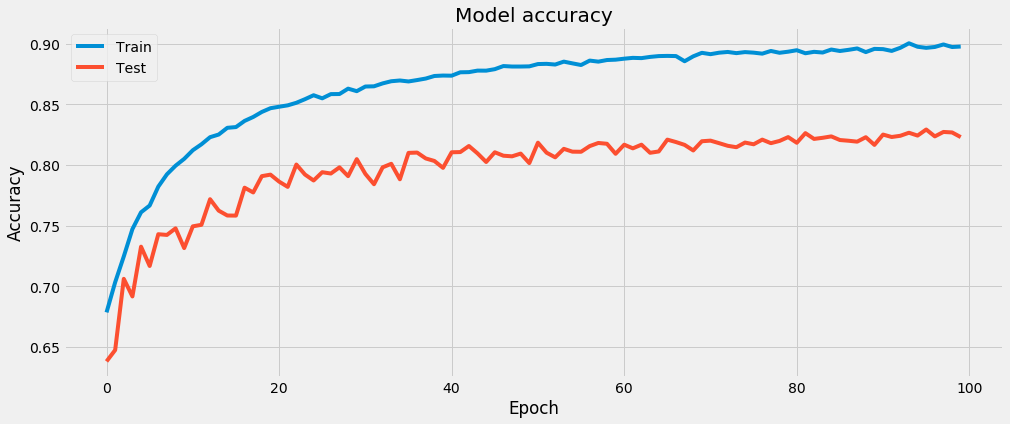

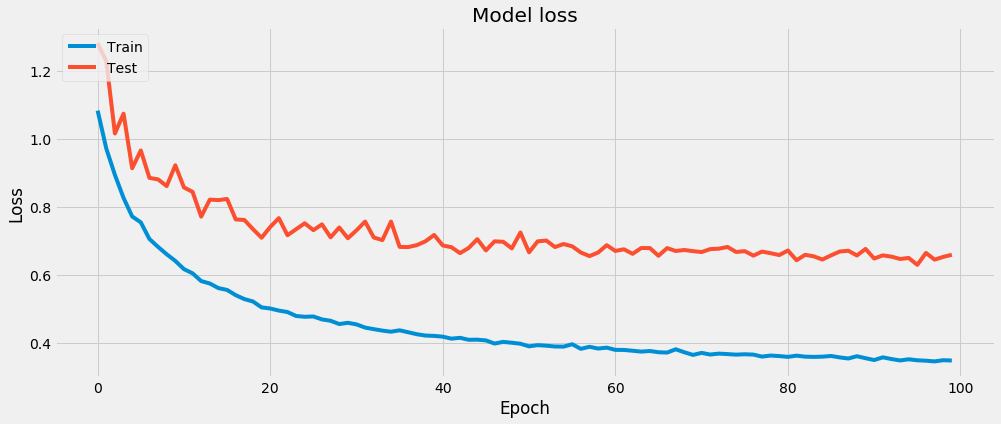

In [42]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Plot training & validation accuracy values
plt.figure(figsize=(15,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [43]:
# evaluate model
model.evaluate(X_test, y_test)

12002/12002 [==============================] - 2s 205us/step


[0.6590439731997314, 0.8229461756373938]

# Classification Report and Confusion Matrix

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
y_pred = model.predict_classes(X_test)

In [0]:
target_name = np.array(df['category'])

In [47]:
print(classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_name))

                  precision    recall  f1-score   support

             dog       0.79      0.79      0.79       258
         rooster       0.72      0.45      0.55       238
             pig       0.91      0.79      0.85       240
             cow       0.80      0.77      0.78       243
            frog       0.98      0.97      0.98       233
             cat       0.70      0.73      0.72       265
             hen       0.88      0.78      0.83       230
         insects       0.93      0.90      0.92       237
           sheep       0.88      0.93      0.91       230
            crow       0.87      0.86      0.86       247
            rain       0.97      1.00      0.98       234
       sea_waves       0.97      0.93      0.95       237
  crackling_fire       0.97      0.91      0.94       276
        crickets       0.94      0.99      0.97       231
  chirping_birds       0.95      0.88      0.92       235
     water_drops       0.88      0.63      0.74       241
            w

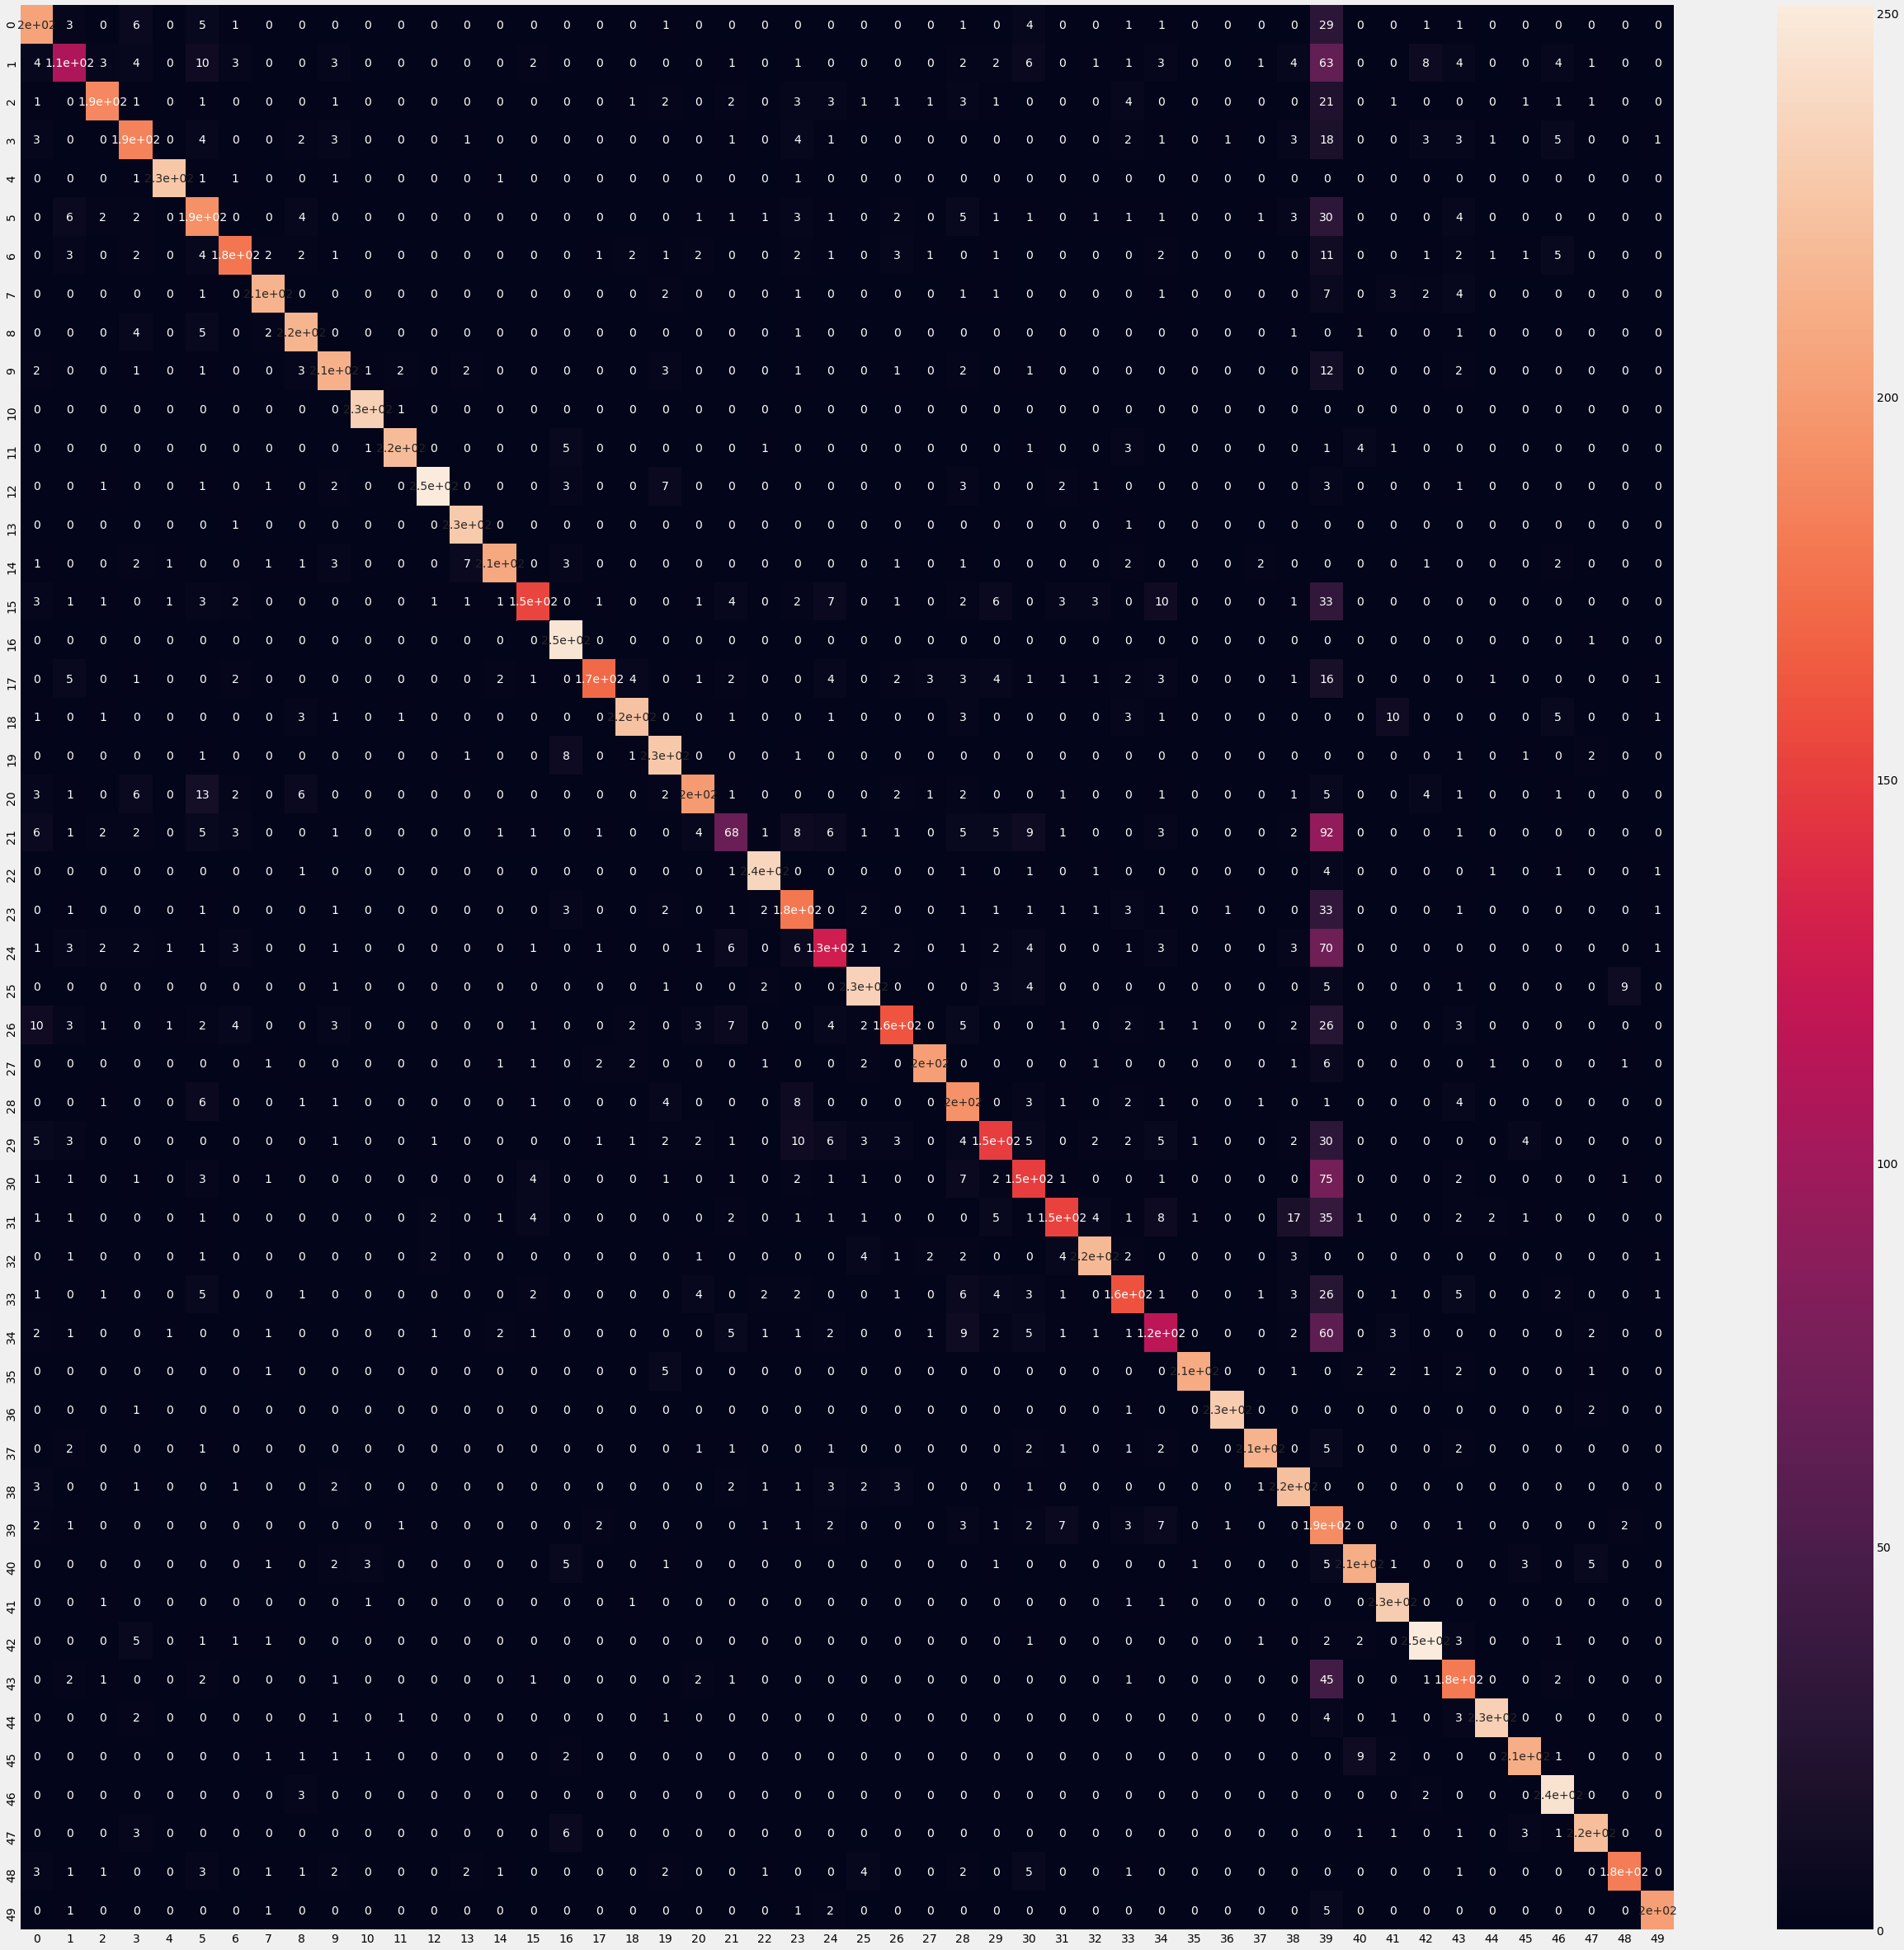

In [48]:
import seaborn as sns
cn_matrix = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
plt.figure(figsize = (40,40))
sns.heatmap(cn_matrix, annot=True)